Vehicle Loan Default Prediction.  
Need for a better credit risk scoring model  
    
Predict the probability   
of loanee/borrower defaulting on a vehicle loan in the **first EMI on the due date**

Two important fields  
1) On Due date  
2) First EMI  

## Initial Setup

For all zero predicted - 0.5


In [0]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
#!pip install plotly_express
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install ipysheet

#Restart Runtime

In [0]:
%%capture false
!apt-get install openjdk-8-jdk
!java -version
!pip install H2O

In [0]:
%%script False
!pip install ipysheet
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

import ipysheet
sheet = ipysheet.sheet()
display(sheet)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))


import shap
from tqdm import tqdm_notebook as tqdm

from sklearn.externals import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
#import catboost as cat

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import h2o
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 34 mins
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_Vasim_pn4y6r
H2O cluster total nodes:,1
H2O cluster free memory:,729 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Instead of flags can we have number of docs 

In [0]:
train_data_og = pd.read_csv("train_new.csv")
sub_data_og = pd.read_csv("test.csv")

# train_data_og = pd.read_csv("drive/My Drive/PyColab Work/LT Vehicle/train_new.csv")
# sub_data_og = pd.read_csv("drive/My Drive/PyColab Work/LT Vehicle/test.csv")

# A lot of categories should be having new codes
#sub_data_og["manufacturer_id"] = sub_data_og["manufacturer_id"].replace(155, 156)

In [0]:
train_data_og.columns

Type Salary & Self Employes and binary, include any one.  
~~Finalize impute option - Missing is third category~~  
~~Manufacturar and StateId try mean encoding~~


In [0]:
def clean_data(dataset):
    dataset = dataset.drop(["UniqueID", "MobileNo_Avl_Flag"], axis = 1) #"Employee_code_ID", "Current_pincode_ID", "supplier_id"
    
    dataset["DisbursalDate"] = pd.to_datetime(dataset["DisbursalDate"], dayfirst=True)
    dataset["Month"] = dataset["DisbursalDate"].dt.month_name()
    
    #dataset["AGE"] = ((pd.to_datetime("1/4/2019", dayfirst = True) - pd.to_datetime(dataset["Date.of.Birth"], dayfirst=True)).dt.days)/365
    #dataset["AGE"] = dataset["AGE"].astype(float)
    
    #dataset["DisbuseAge"] = ((pd.to_datetime("1/4/2019", dayfirst = True) - pd.to_datetime(dataset["DisbursalDate"], dayfirst=True)).dt.days)
    
    #dataset[["branch_id", "manufacturer_id", "State_ID"]] = dataset[["branch_id", "manufacturer_id", "State_ID"]].astype("str")
    
    #dataset["NoOfDocs"] = dataset["Aadhar_flag"] + dataset["PAN_flag"] + dataset["VoterID_flag"] + dataset["Driving_flag"] + dataset["Passport_flag"]
    
    dataset["CREDIT.HISTORY.LENGTH"] = dataset["CREDIT.HISTORY.LENGTH"].str.replace("yrs", "", regex = True).str.replace(" ", ".", regex = True).str.replace("mon", "", regex = True)
    dataset["AVERAGE.ACCT.AGE"] = dataset["AVERAGE.ACCT.AGE"].str.replace("yrs", "", regex = True).str.replace(" ", ".", regex = True).str.replace("mon", "", regex = True)
    
    dataset[["CREDIT.HISTORY.LENGTH", "AVERAGE.ACCT.AGE"]] = dataset[["CREDIT.HISTORY.LENGTH", "AVERAGE.ACCT.AGE"]].astype(float)
    
    dataset = dataset.drop(["Date.of.Birth", "Employee_code_ID", "Current_pincode_ID", "supplier_id",
                           "SEC.NO.OF.ACCTS", "SEC.ACTIVE.ACCTS", "SEC.SANCTIONED.AMOUNT", "SEC.DISBURSED.AMOUNT",
                           "SEC.OVERDUE.ACCTS", "SEC.CURRENT.BALANCE", "SEC.INSTAL.AMT"], axis = 1)
    
    # branch_id, "Aadhar_flag", "PAN_flag", "VoterID_flag", "Driving_flag", "Passport_flag", "NEW.ACCTS.IN.LAST.SIX.MONTHS"
    # "PRI.ACTIVE.ACCTS" "PRI.SANCTIONED.AMOUNT", "PRI.DISBURSED.AMOUNT", 
                            #"PRI.OVERDUE.ACCTS",
                            #"PRI.CURRENT.BALANCE", "PRI.NO.OF.ACCTS"
    
    # str.strip().str.lower()
    dataset.columns = dataset.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '_') 
    return dataset

train_data = clean_data(train_data_og)
train_data = train_data.query("PERFORM_CNS_SCORE_DESCRIPTION != 'Not Scored: More than 50 active Accounts found'") #As this is not in submission set
sub_data = clean_data(sub_data_og)


## MEAN ENCODING #Use time based mean encoding instead. 

#### CAN WE PERFORM DATALEAK HERE!!!!!!
# Define a def <- send in below function
means = train_data.groupby('PERFORM_CNS_SCORE_DESCRIPTION')['loan_default'].mean()
train_data["PERFORM_CNS_SCORE_DESCRIPTION_3m"] = train_data["PERFORM_CNS_SCORE_DESCRIPTION"].map(means)
sub_data["PERFORM_CNS_SCORE_DESCRIPTION_3m"] = sub_data["PERFORM_CNS_SCORE_DESCRIPTION"].map(means)


means = train_data.groupby('manufacturer_id')['loan_default'].mean()
train_data["manufacturer_id_3m"] = train_data["manufacturer_id"].map(means)
sub_data["manufacturer_id_3m"] = sub_data["manufacturer_id"].map(means)

means = train_data.groupby('State_ID')['loan_default'].mean()
train_data["State_ID_3m"] = train_data["State_ID"].map(means)
sub_data["State_ID_3m"] = sub_data["State_ID"].map(means)

means = train_data.groupby('branch_id')['loan_default'].mean()
train_data["branch_id_3m"] = train_data["branch_id"].map(means)
sub_data["branch_id_3m"] = sub_data["branch_id"].map(means)

# Drop these categorical fields

#train_data.head(10).T

In [26]:
catlist = ["State_ID", "PERFORM_CNS_SCORE_DESCRIPTION", "branch_id", "manufacturer_id"]

def update_monthly_lag(trainset, subset) :
    
    for i in catlist :
    
        lagged = trainset.groupby([i, 'Month'])['loan_default'].mean().reset_index()
        lagged = pd.pivot(lagged, index = i, columns = "Month" ,values = "loan_default").reset_index()

        lagged.columns = [i,  i + "_Aug", i + "_Sep", i + "_Oct"]
        
        trainset = pd.merge(trainset, lagged, "left", on = i)
        subset = pd.merge(subset, lagged, "left", on = i)
        
    return trainset, subset

train_data, sub_data = update_monthly_lag(train_data, sub_data)
train_data = train_data.drop(catlist + ["DisbursalDate"], axis = 1)

# There are na when merging, since there may be new values in any catlist field
train_data = train_data.fillna(0)

train_data.head().T

,0,1,2,3,4
disbursed_amount,50578,47145,53278,57513,52378
asset_cost,58400,65550,61360,66113,60300
ltv,89.55,73.23,89.63,88.48,88.39
Employment_Type,Salaried,Self employed,Self employed,Self employed,Self employed
Aadhar_flag,1,1,1,1,1
PAN_flag,0,0,0,0,0
VoterID_flag,0,0,0,0,0
Driving_flag,0,0,0,0,0
Passport_flag,0,0,0,0,0
PERFORM_CNS_SCORE,0,598,0,305,0


In [5]:
train_data.isna().any().any()

False

**LAG 1 Month MEAN ENCODING**  
~~Actual Count~~  count  
~~Frequency~~  freq  
~~Loan Default count~~   Dsum  
~~Percentage of default count~~  Dfreq  
Non Default count  
Average default  


In [0]:

def lag_encoding(newmonth, oldmonth, collist, method, target = "loan_default"):
    
    """
    cnt = count of value in entire set. eg No of times 45 occurs in data
    Dsum = count of defaults
    freq = %age value in in set. cnt / len(dataset)
    Dfreq = %age of defaults. Dsum / cnt (see Note 1)
    
    Additional Info
    Note 1 = Divide by cnt and not len(dataaset)
    """
    
    freq = lambda x: len(x) / len(oldmonth)
    count = lambda x: len(x)
    Dfreq = lambda x: sum(x) / len(x)
    #zero = lambda x: 
    
    switcher = {"freq":freq, "Dsum" : sum, "cnt": count, "Dfreq" : Dfreq}
    
    for i in collist:
        simple_count = oldmonth.groupby(i)[target].agg(switcher.get(method, "nothing"))
        newmonth[i + "_n_" + method] = newmonth[i].map(simple_count)
        
    return(newmonth)

In [0]:
augset = train_data[(train_data["DisbursalDate"] > pd.to_datetime("2018-07-31")) & (train_data["DisbursalDate"] <= pd.to_datetime("2018-08-31"))]
sepset = train_data[(train_data["DisbursalDate"] > pd.to_datetime("2018-08-31")) & (train_data["DisbursalDate"] <= pd.to_datetime("2018-09-30"))]
octset = train_data[(train_data["DisbursalDate"] > pd.to_datetime("2018-09-30")) & (train_data["DisbursalDate"] <= pd.to_datetime("2018-10-31"))]

novset = sub_data[(sub_data["DisbursalDate"] > pd.to_datetime("2018-10-31")) & (sub_data["DisbursalDate"] <= pd.to_datetime("2018-11-30"))]

In [0]:
# Run in combination with above code

catlist = ["manufacturer_id", "State_ID", "PERFORM_CNS_SCORE_DESCRIPTION", "branch_id"]

#sepset = lag_encoding(sepset, augset, catlist, "cnt")
sepset = lag_encoding(sepset, augset, catlist, "freq")
sepset = lag_encoding(sepset, augset, catlist, "Dsum")
sepset = lag_encoding(sepset, augset, catlist, "Dfreq")


#octset = lag_encoding(octset, sepset, catlist, "cnt")
octset = lag_encoding(octset, sepset, catlist, "freq")
octset = lag_encoding(octset, sepset, catlist, "Dsum")
octset = lag_encoding(octset, sepset, catlist, "Dfreq")


#novset = lag_encoding(novset, octset, catlist, "cnt")
novset = lag_encoding(novset, octset, catlist, "freq")
novset = lag_encoding(novset, octset, catlist, "Dsum")
novset = lag_encoding(novset, octset, catlist, "Dfreq")

#Low cardinality - Employee_code_ID, Current_pincode_ID, supplier_id
#removed "PERFORM_CNS_SCORE_DESCRIPTION"
delcatlist = ["manufacturer_id", "State_ID", "branch_id"]

sepset = sepset.drop(catlist, axis = 1)
octset = octset.drop(catlist, axis = 1)
novset = novset.drop(catlist, axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
### USE WITH CAUTION - DO NOT USE THIS WITH ABOVE MEAN ENCODE, USE IT WITHOUT MONTHLY ENCODING ###

#With out mean encoding, 2 months for train and 1 month test
catlist = ["loan_default", "DisbursalDate", "manufacturer_id", "State_ID", "PERFORM_CNS_SCORE_DESCRIPTION", "branch_id"]

X_train = pd.concat([augset, sepset], axis = 0)
X_train = sepset.drop(catlist, axis = 1)
X_train = pd.get_dummies(X_train, dummy_na = True)
y_train = sepset["loan_default"]

X_test = octset.drop(catlist, axis = 1)
X_test = pd.get_dummies(X_test, dummy_na = True)
y_test = octset["loan_default"]

X_sub = novset.drop(["DisbursalDate", "manufacturer_id", "State_ID", "PERFORM_CNS_SCORE_DESCRIPTION", "branch_id"], axis = 1)
X_sub = pd.get_dummies(X_sub, dummy_na = True)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_sub = X_sub.fillna(0)

In [0]:
### USE THIS OR ABOVE ###
X_train = sepset.drop(["loan_default", "DisbursalDate"], axis = 1)
X_train = pd.get_dummies(X_train, dummy_na = True)
y_train = sepset["loan_default"]

X_test = octset.drop(["loan_default", "DisbursalDate"], axis = 1)
X_test = pd.get_dummies(X_test, dummy_na = True)
y_test = octset["loan_default"]

X_sub = novset.drop(["DisbursalDate"], axis = 1)
X_sub = pd.get_dummies(X_sub, dummy_na = True)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_sub = X_sub.fillna(0)

In [0]:
print("Train set has %s rows, %s cols and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set has %s rows, %s cols and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set has %s rows, %s cols and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set has 66787 rows, 36 cols and y is 66787
Test set has 98363 rows, 36 cols and y is 98363
Submission set has 112392 rows, 36 cols and y is to be predicted


In [0]:
X_train.head()

,disbursed_amount,asset_cost,ltv,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,...,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,NoOfDocs,PERFORM_CNS_SCORE_DESCRIPTION_all,manufacturer_id_all,State_ID_all,branch_id_all,Employment_Type_Salaried,Employment_Type_Self employed,Employment_Type_nan
1,47145,65550,73.23,1,0,0,0,0,598,1,...,1.11,0,1.0,27.262912,22.850735,20.564095,19.403249,0,1,0
4,52378,60300,88.39,1,0,0,0,0,0,0,...,0.00,1,1.0,23.131253,22.850735,20.564095,19.403249,0,1,0
5,54513,61900,89.66,1,0,0,0,0,825,2,...,2.00,0,1.0,16.574625,22.850735,20.564095,19.403249,0,1,0
6,46349,61500,76.42,1,0,0,0,0,0,0,...,0.00,0,1.0,23.131253,22.850735,20.564095,19.403249,1,0,0
7,43894,61900,71.89,1,0,0,0,0,17,1,...,0.20,0,1.0,20.969499,22.850735,20.564095,19.403249,1,0,0


In [0]:
octset.manufacturer_id.value_counts() #153 New

In [0]:
novset.manufacturer_id.value_counts() #155 New

In [0]:
X_train.isna().any().sum()

0

In [0]:
X_test.isna().any().sum()

0

In [0]:
X_sub.isna().any().sum()

0

In [0]:
X_train.columns.tolist()

In [0]:
# augset[["manufacturer_id", "loan_default"]].query("manufacturer_id == 45")["loan_default"].agg('count') #16214
# augset[["manufacturer_id", "loan_default"]].query("manufacturer_id == 45")["loan_default"].sum() #3810


## EDA

### Outliers

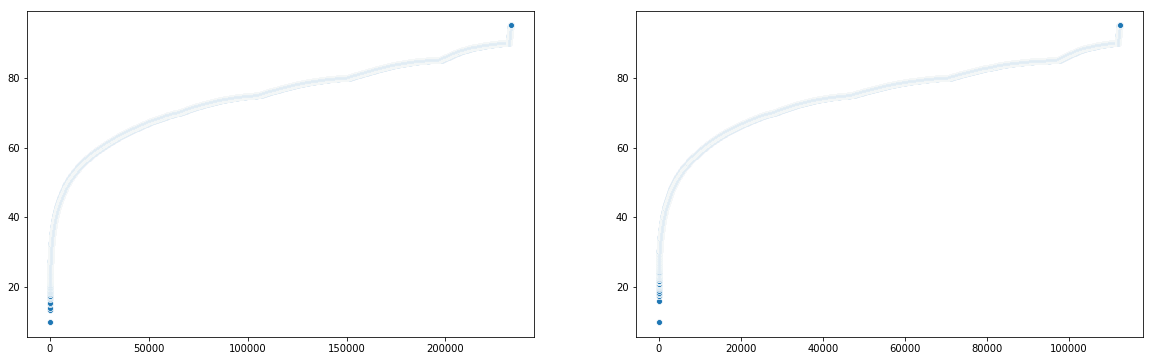

In [0]:
plt.subplot(1,2,1)
sns.scatterplot(np.arange(len(train_data)), np.sort(train_data["ltv"]), )
plt.subplot(1,2,2)
sns.scatterplot(np.arange(len(sub_data)), np.sort(sub_data["ltv"]))


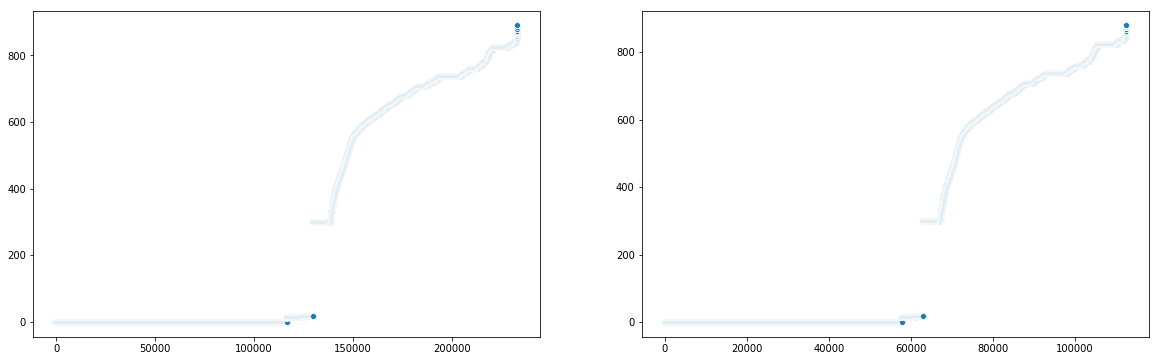

In [0]:
plt.subplot(1,2,1)
sns.scatterplot(np.arange(len(train_data)), np.sort(train_data["PERFORM_CNS.SCORE"]), )
plt.subplot(1,2,2)
sns.scatterplot(np.arange(len(sub_data)), np.sort(sub_data["PERFORM_CNS.SCORE"]))

#There are some 1, what are they?

### Categorical Values

In [0]:
plt.figure(figsize = (20, 10))
plt.subplot(3,2,1)
sns.countplot(train_data["branch_id"], order = train_data["branch_id"].value_counts().index)
plt.subplot(3,2,2)
sns.countplot(sub_data["branch_id"], order = train_data["branch_id"].value_counts().index)

plt.subplot(3,2,3)
sns.countplot(train_data["manufacturer_id"], order = train_data["manufacturer_id"].value_counts().index)
plt.subplot(3,2,4)
sns.countplot(sub_data["manufacturer_id"], order = train_data["manufacturer_id"].value_counts().index)

plt.subplot(3,2,5)
sns.countplot(train_data["State_ID"], order = train_data["State_ID"].value_counts().index)
plt.subplot(3,2,6)
sns.countplot(sub_data["State_ID"], order = train_data["State_ID"].value_counts().index)

In [0]:
# It has blanks why is it not showing?
sns.countplot(train_data["Employment.Type"])

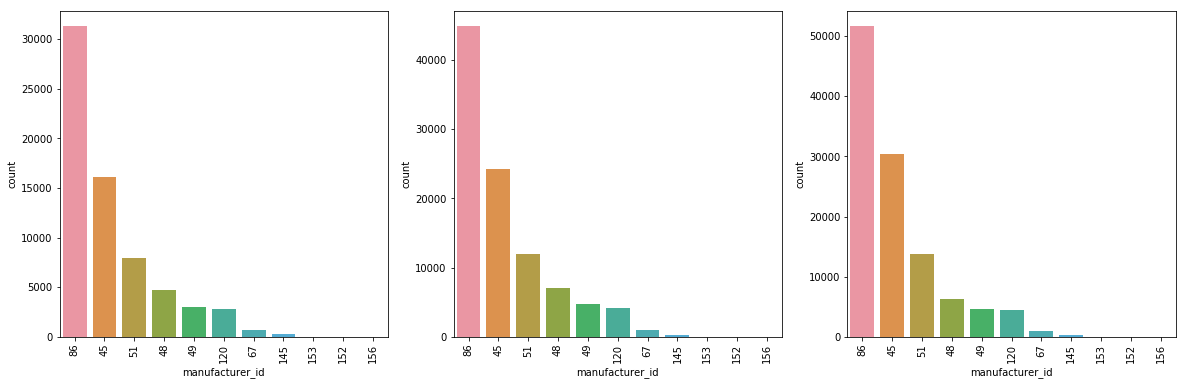

In [0]:
plt.subplot(1,3,1)
sns.countplot(sepset["manufacturer_id"], order = train_data_og["manufacturer_id"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,2)
sns.countplot(octset["manufacturer_id"], order = train_data_og["manufacturer_id"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
sns.countplot(novset["manufacturer_id"], order = train_data_og["manufacturer_id"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

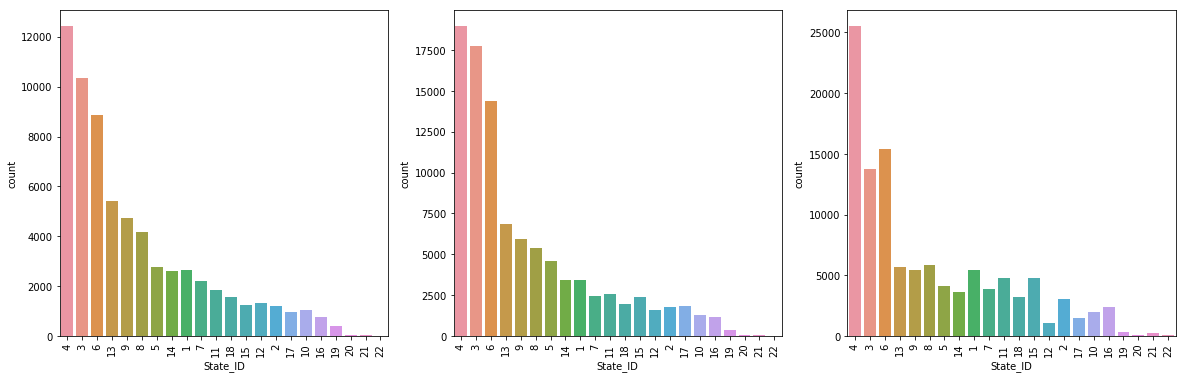

In [0]:
plt.subplot(1,3,1)
sns.countplot(sepset["State_ID"], order = train_data_og["State_ID"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,2)
sns.countplot(octset["State_ID"], order = train_data_og["State_ID"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
sns.countplot(novset["State_ID"], order = train_data_og["State_ID"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

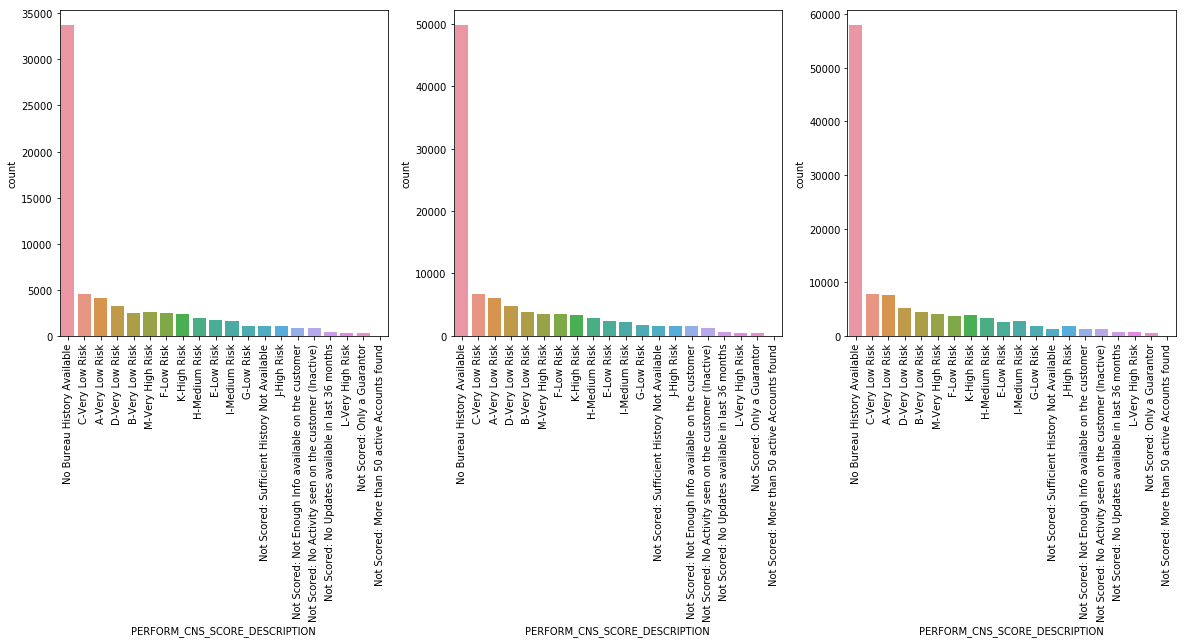

In [0]:
plt.subplot(1,3,1)
sns.countplot(sepset["PERFORM_CNS_SCORE_DESCRIPTION"], order = train_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,2)
sns.countplot(octset["PERFORM_CNS_SCORE_DESCRIPTION"], order = train_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
sns.countplot(novset["PERFORM_CNS_SCORE_DESCRIPTION"], order = train_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Bivariate

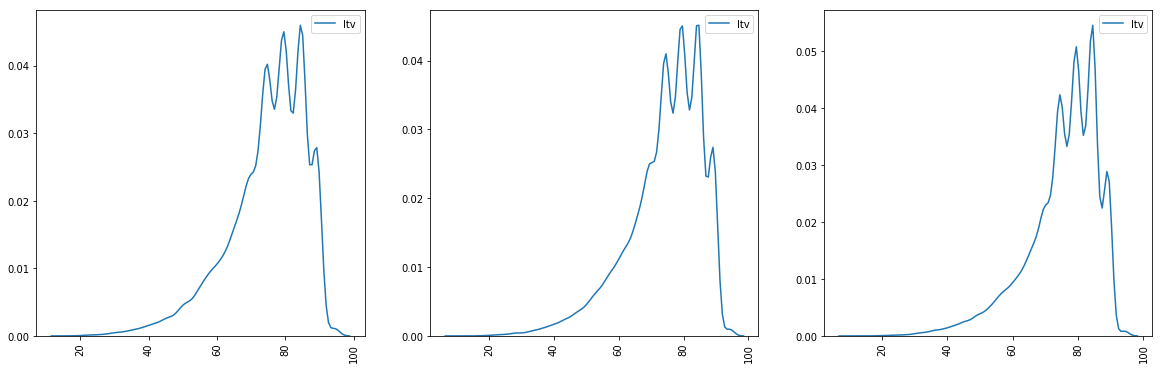

In [0]:
plt.subplot(1,3,1)
sns.kdeplot(sepset["ltv"])
plt.xticks(rotation = 90)
plt.subplot(1,3,2)
sns.kdeplot(octset["ltv"])
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
sns.kdeplot(novset["ltv"])
plt.xticks(rotation = 90)
plt.show()

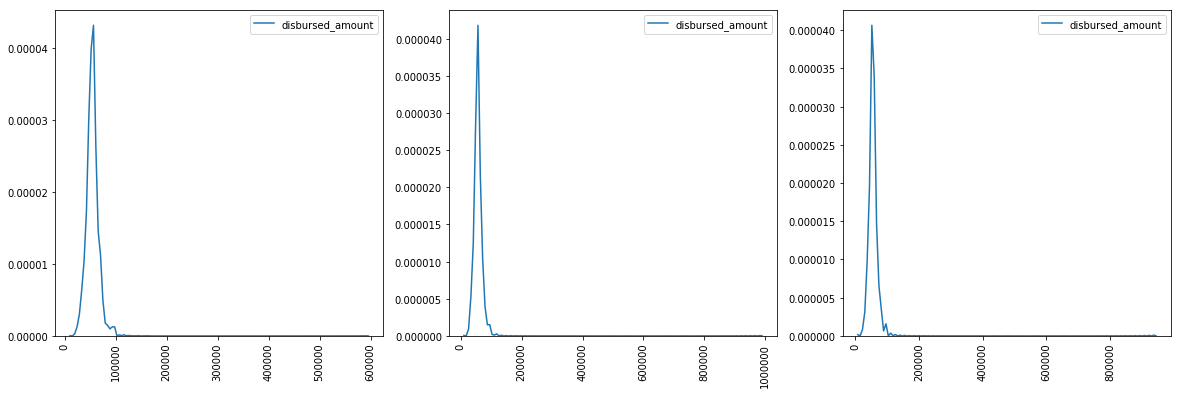

In [0]:
plt.subplot(1,3,1)
sns.kdeplot(sepset["disbursed_amount"])
plt.xticks(rotation = 90)
plt.subplot(1,3,2)
sns.kdeplot(octset["disbursed_amount"])
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
sns.kdeplot(novset["disbursed_amount"])
plt.xticks(rotation = 90)
plt.show()

### Time Based EDA

Try with manufacture id

Train Set  
Aug 18 - 68,002  (48,221 = 0 - 71%) (13,091 = 1 - 19%)  
Sep 18 - 66,788  (53,973 = 0 - 80%) (12,815 = 1 - 20%)   
Oct 18 - 98,364  (75,234 = 0 - 76%) (23,130 = 1 - 24%)

Test Set  
1,12,392 - Nov 18  (75% - 25%)


https://www.kaggle.com/sudalairajkumar/winning-solutions-of-kaggle-competitions

Rossmann Store Sales competition  
Grupo Bimbo Inventory Demand  


In [0]:
train_dates = pd.to_datetime(train_data_og["DisbursalDate"], dayfirst=True)
sub_dates = pd.to_datetime(sub_data_og["DisbursalDate"], dayfirst=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


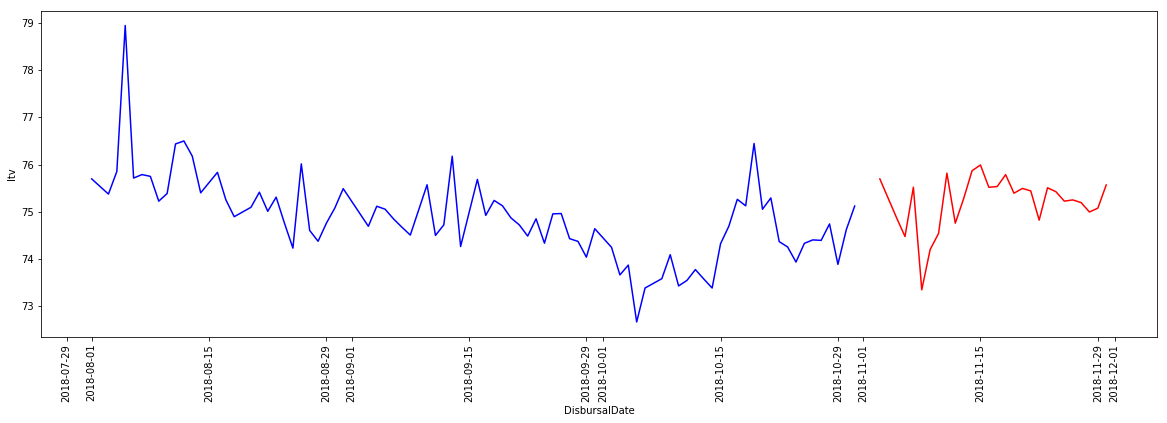

In [0]:
# plt.subplot(1,2,1)
sns.lineplot(train_dates, train_data_og["ltv"], c = "b", ci = None, )
sns.lineplot(sub_dates, sub_data_og["ltv"], c = "r", ci = None)
plt.xticks(rotation = 90)
plt.show()

In [0]:
print(np.min(train_dates)) 
print(np.max(train_dates))
print(np.min(sub_dates)) 
print(np.max(sub_dates))

2018-08-01 00:00:00
2018-10-31 00:00:00
2018-11-03 00:00:00
2018-11-30 00:00:00


## Validation

Train Set  
Aug 18 - 68,002  (48221 = 0 - 71%) (13091 = 1 - 19%)  
Sep 18 - 66,788  (53973 = 0 - 80%) (12815 = 1 - 20%)   
Oct 18 - 98,364  (75234 = 0 - 76%) (23130 = 1 - 24%)

Test Set  
1,12,392 - Nov 18  

In [0]:
%%script False

# No longer needed as splits are based on time

trainset = train_data[(train_data["DisbursalDate"] > pd.to_datetime("2018-07-31")) & (train_data["DisbursalDate"] <= pd.to_datetime("2018-09-30"))]
testset = train_data[(train_data["DisbursalDate"] > pd.to_datetime("2018-09-30")) & (train_data["DisbursalDate"] <= pd.to_datetime("2018-10-31"))]

# To be used for full model
X = train_data.drop(["DisbursalDate","loan_default"], axis = 1)
X = pd.get_dummies(X, dummy_na = True)
y = train_data["loan_default"]


X_train = trainset.drop(["DisbursalDate","loan_default"], axis = 1)
X_train = pd.get_dummies(X_train, dummy_na = True)
y_train = trainset["loan_default"]

X_test = testset.drop(["DisbursalDate","loan_default"], axis = 1)
X_test = pd.get_dummies(X_test, dummy_na = True)
y_test = testset["loan_default"]

X_sub = sub_data.drop(["DisbursalDate"], axis = 1)
X_sub = pd.get_dummies(X_sub, dummy_na = True)
y = train_data["loan_default"]

In [0]:
#Month 8 ,9 & 10
# Compared with OG data, there are 2 and 1 missing.
68002  + 66788 # 98364

134790

In [0]:
#print("Full set has %s rows, %s cols and y is %s" % (X.shape[0], X.shape[1], y.shape[0]))
print("Train set has %s rows, %s cols and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set has %s rows, %s cols and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set has %s rows, %s cols and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set has 66787 rows, 24 cols and y is 66787
Test set has 98363 rows, 24 cols and y is 98363
Submission set has 112392 rows, 24 cols and y is to be predicted


In [0]:
X_train.head()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS_SCORE,PRIMARY_INSTAL_AMT,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,manufacturer_id_n_cnt,...,PERFORM_CNS_SCORE_DESCRIPTION_n_freq,manufacturer_id_n_Dsum,State_ID_n_Dsum,PERFORM_CNS_SCORE_DESCRIPTION_n_Dsum,manufacturer_id_n_Dfreq,State_ID_n_Dfreq,PERFORM_CNS_SCORE_DESCRIPTION_n_Dfreq,Employment_Type_Salaried,Employment_Type_Self employed,Employment_Type_nan
1,47145,65550,73.23,598,1991,1,1.11,1.11,0,16214.0,...,0.023426,3810.0,2151,401,0.234982,0.210059,0.251726,0,1,0
4,52378,60300,88.39,0,0,0,0.00,0.00,1,16214.0,...,0.492596,3810.0,2151,8004,0.234982,0.210059,0.238947,0,1,0
5,54513,61900,89.66,825,1347,0,1.90,2.00,0,16214.0,...,0.058926,3810.0,2151,656,0.234982,0.210059,0.163714,0,1,0
6,46349,61500,76.42,0,0,0,0.00,0.00,0,16214.0,...,0.492596,3810.0,2151,8004,0.234982,0.210059,0.238947,1,0,0
7,43894,61900,71.89,17,0,0,0.20,0.20,0,16214.0,...,0.017162,3810.0,2151,249,0.234982,0.210059,0.213368,1,0,0


### Validation Plots

**Finally, after so much of effort it paid off, train/sub split is based on DisbursalDate**

X_train and X_sub

0.5923694744256718

Is unique used in some combination for split.

Checked

**Issue**  
LTV - at around 80% there is some problem.  
~~LTV + ManufacturerID~~  
PRIMARY_INSTAL_AMT - EMI can be 1 Rs to 1.5cr (highly variance) - Dist Highly mismatch    
NO_OF_INQUIRIES - Not match  
Employment_Type_Salaried   - Not so good

**Non issue**     
manufacturar id - Good  
PERFORM_CNS_SCORE_DESCRIPTION = full data is slightly different on x-axis, test and sub match   
State_ID - Good
Employment_Type_nan - Good  
Employment_Type_Self employed - Good  




In [0]:
train_data_og.columns.tolist()

['UniqueID',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'branch_id',
 'supplier_id',
 'manufacturer_id',
 'Current_pincode_ID',
 'Date.of.Birth',
 'Employment.Type',
 'DisbursalDate',
 'State_ID',
 'Employee_code_ID',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.CURRENT.BALANCE',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'SEC.NO.OF.ACCTS',
 'SEC.ACTIVE.ACCTS',
 'SEC.OVERDUE.ACCTS',
 'SEC.CURRENT.BALANCE',
 'SEC.SANCTIONED.AMOUNT',
 'SEC.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'SEC.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES',
 'loan_default',
 'MP']

In [0]:
pd.DataFrame(train_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].astype(str) + train_data_og["manufacturer_id"].astype(str))[0].value_counts()

In [0]:
sub_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].astype(str) + sub_data_og["manufacturer_id"].astype(str)

In [0]:
train_data_og["MP"] = train_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].astype(str) + train_data_og["manufacturer_id"].astype(str)
sub_data_og["MP"] = sub_data_og["PERFORM_CNS.SCORE.DESCRIPTION"].astype(str) + sub_data_og["manufacturer_id"].astype(str)

In [0]:
plt.figure(figsize = (40, 5))
plt.subplot(1,2,1)
sns.boxplot(train_data_og["MP"], train_data_og["ltv"], order = train_data_og["MP"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.boxplot(sub_data_og["MP"], sub_data_og["ltv"], order = train_data_og["MP"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

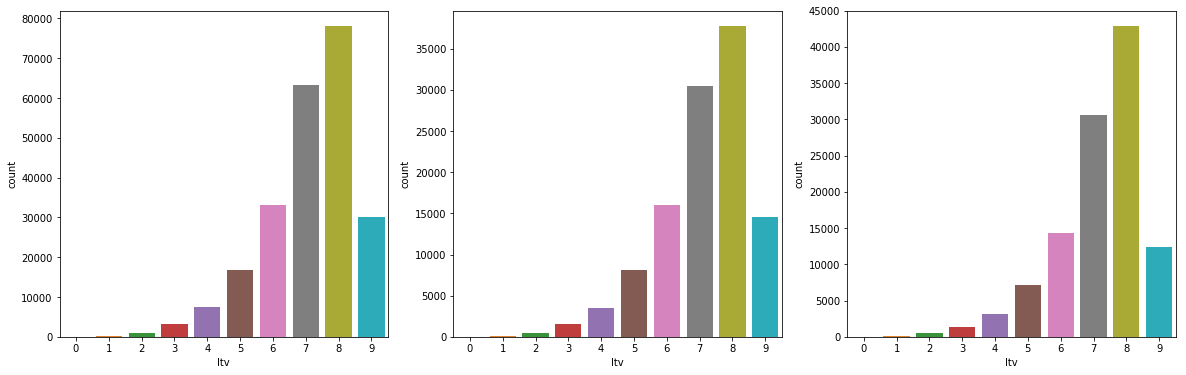

In [0]:
plt.subplot(1,3,1)
sns.countplot(X["ltv"])
plt.subplot(1,3,2)
sns.countplot(X_test["ltv"])
plt.subplot(1,3,3)
sns.countplot(X_sub["ltv"])
plt.show()

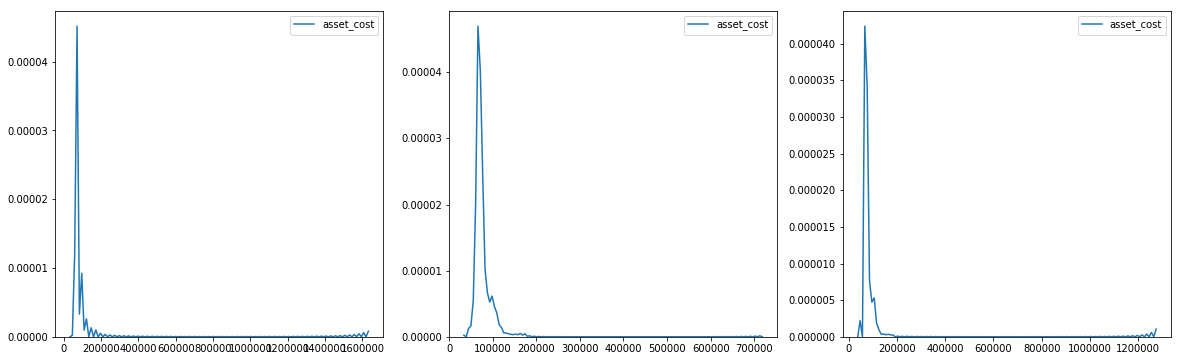

In [0]:
plt.subplot(1,3,1)
sns.kdeplot(X["asset_cost"])
plt.subplot(1,3,2)
sns.kdeplot(X_test["asset_cost"])
plt.subplot(1,3,3)
sns.kdeplot(X_sub["asset_cost"])
plt.show()

In [0]:
print(X_test["Employment_Type_Salaried"].value_counts() / len(X_test))
print(X_sub["Employment_Type_Salaried"].value_counts() / len(X_sub))

0    0.580159
1    0.419841
Name: Employment_Type_Salaried, dtype: float64
0    0.562647
1    0.437353
Name: Employment_Type_Salaried, dtype: float64


In [0]:
print(X_test["Employment_Type_Self employed"].value_counts() / len(X_test))
print(X_sub["Employment_Type_Self employed"].value_counts() / len(X_sub))

1    0.547463
0    0.452537
Name: Employment_Type_Self employed, dtype: float64
1    0.532013
0    0.467987
Name: Employment_Type_Self employed, dtype: float64


In [0]:
print(X_test["Employment_Type_nan"].value_counts() / len(X_test))
print(X_sub["Employment_Type_nan"].value_counts() / len(X_sub))

0    0.967304
1    0.032696
Name: Employment_Type_nan, dtype: float64
0    0.969366
1    0.030634
Name: Employment_Type_nan, dtype: float64


## Modelling

Leaderboard - 67%

In [0]:
weight = 3.75 # (y_train + y_test / 2)

### SUBMIT FILE

In [0]:

#Overfitting - 57%
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

sub_model = xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight = weight, n_estimators = 1020)
sub_model.fit(X, y, eval_metric = "auc")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1020,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3.75, seed=None,
       silent=True, subsample=1)

In [0]:
pd.DataFrame({ "UniqueID" : sub_data_og["UniqueID"], "loan_default" : sub_model.predict(X_sub) }, index = None).to_csv("LT_submit.csv", index = False)

### XGBOOST MODEL

#### PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

pca = PCA(n_components = 4)
pca.fit(X_train)

In [0]:
#SCREE PLOT
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 47, 1.0))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [0]:
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

#### XGBoost Single - 0.5819%

In [0]:
xgb_model = xgb.XGBClassifier(learning_rate=0.001, n_estimators = 100000)
xgb_model.fit(X_train, y_train, eval_metric = "auc", eval_set = [(X_test, y_test), (X_train, y_train)], verbose = 1000, early_stopping_rounds=10)

joblib.dump(xgb_model, "drive/My Drive/PyColab Work/LT Vehicle/xgb_model.sav")

[0]	validation_0-auc:0.59555	validation_1-auc:0.614177
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[8]	validation_0-auc:0.595462	validation_1-auc:0.61427



['drive/My Drive/PyColab Work/LT Vehicle/xgb_model.sav']

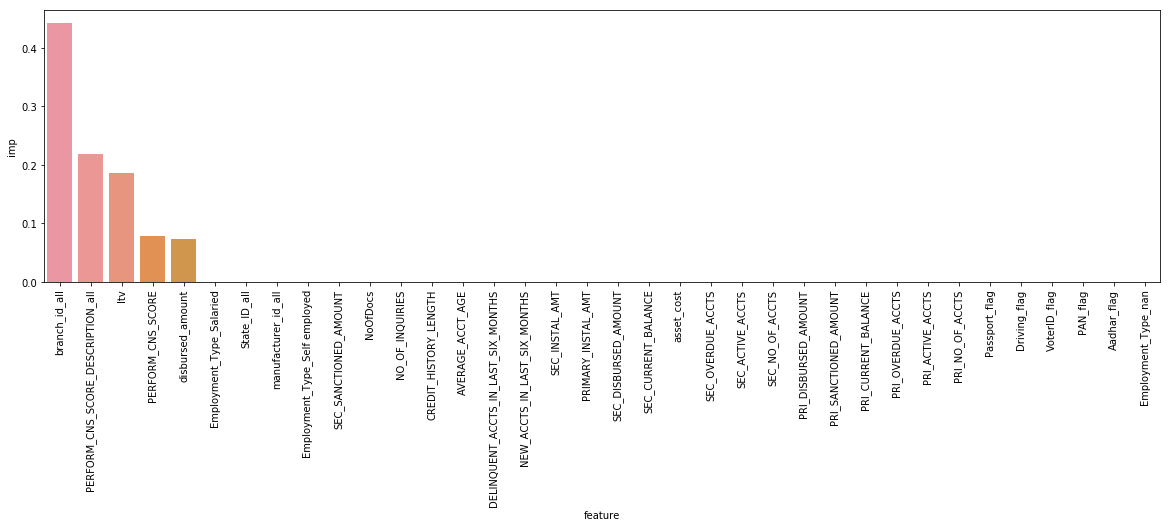

In [0]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

In [0]:
confusion_matrix(y_train, xgb_model.predict(X_train))

array([[35759, 18213],
       [ 5183,  7632]])

In [0]:
%%script False
# fpr, tpr, thresholds = roc_curve(y_train, xgb_model.predict_proba(X_train)[:,1])
# auc(fpr, tpr)
#OR
roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1])

0.6195433126368044

In [0]:
confusion_matrix(y_test, xgb_model.predict(X_test))

array([[55634, 19599],
       [12846, 10284]])

In [0]:
#%%script False
# fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
# auc(fpr, tpr)
#OR
roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]) #0.5987681017582798

0.6437699395316797

#### SHAP

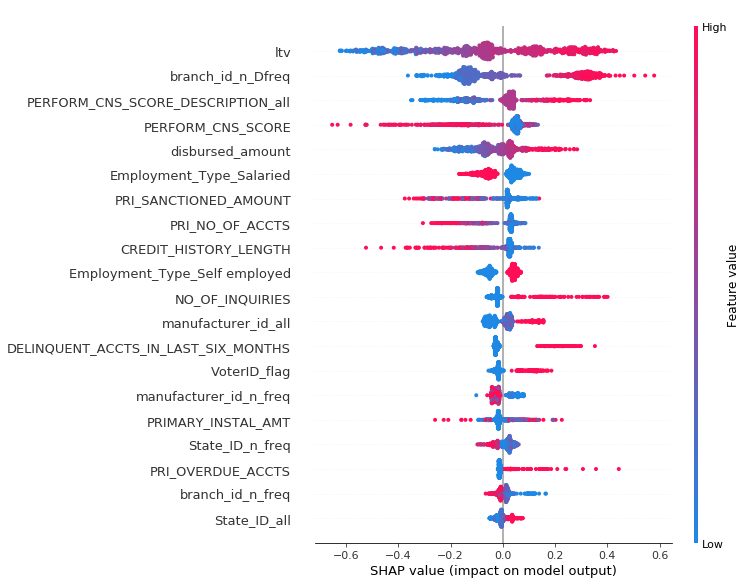

In [0]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

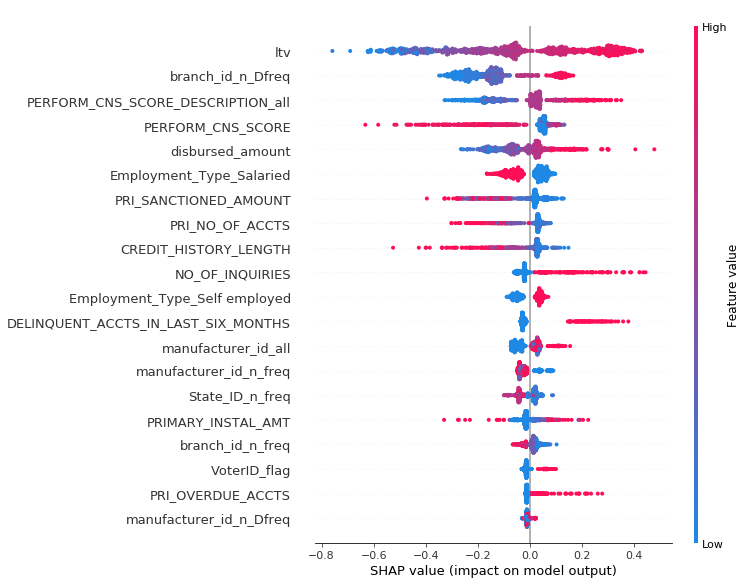

In [0]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter tuning

jupyter notebook \ --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=8888 \ --NotebookApp.port_retries=0

In [0]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBClassifier() # learning rate and rounds in params

xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 6, 10], 
              'gamma' : [0], 
              'learning_rate' : [0.001], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5], 
              'subsample' : [1], 
              'colsample_bytree' : [1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_metric = "auc", eval_set = [(X_test, y_test), (X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

In [0]:
xgb_grid.best_params_

### LightGBM

#### LightGBM single - (51%)

In [0]:
#scale_pos_weight = weight of labels with positive class

In [0]:
lgb_model = lgb.LGBMClassifier(objective = "binary", scale_pos_weight = weight, n_estimators = 100, learning_rate = 0.01)

lgb_model.fit(X_train, y_train, eval_metric = ["auc"], eval_set = [(X_train, y_train), (X_test, y_test)], 
              eval_names = ["Train", "Test"], verbose=50)

[50]	Train's auc: 0.674002	Train's binary_logloss: 0.499757	Test's auc: 0.635262	Test's binary_logloss: 0.536088
[100]	Train's auc: 0.683169	Train's binary_logloss: 0.530588	Test's auc: 0.63978	Test's binary_logloss: 0.548086


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=3.75, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [0]:
print(confusion_matrix(y_train, lgb_model.predict(X_train)))
#print(roc_auc_score(y_train, lgb_model.predict_proba(X_train)[:,1]))

[[134696   2210]
 [ 36253   1706]]


In [0]:
print(confusion_matrix(y_test, lgb_model.predict(X_test)))
#print(roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1]))

[[44875   762]
 [12095   557]]


### XGBoost downsample Bagged

Almost same result as XGBoost with weights, use that instead.

Now that time series got involved a lot will change.

In [0]:
train_data.loan_default.value_counts()

In [0]:
train_data.drop(["loan_default"], axis = 1).shape

In [0]:
def downsample_and_bag(dataset, y = "loan_default", nbags=3, full = False, outset = sub_data) :
    """ 
    Bag with downsample. More soon!
    
    dataset = data to use eg (iris)
    y = label y (Species)
    nbags = number of rounds to downsample the majority class.
    full = If True, do not split train test, else split train test
    outset = If full is false then not in use, if True then this set is used to make predictions. 
    
    Additional Info:
        For dataset and outset, categories should not be dummy encoded.
        Use odd numbers in nbags to avoid ties
    """
    
    test_pred = []
    outcome = []
    
    # Initial splt, this split (X_train) gets changed when downsized.
    dataset = pd.get_dummies(dataset, dummy_na = True)
    X_sub = pd.get_dummies(outset, dummy_na = True)
    
    #Should'nt this be in loop?
    X_train, X_test = train_test_split(dataset, test_size = 0.25, train_size = 0.75)
    
    #downpercentage = dataset[y].value_counts()[1] / len(dataset)
    downpercentage = 0.276 #for entire train_data #Same prop for X_train as well?
    #print(downpercentage)
    
    # Get 0's dataset
    minor_class = X_train[X_train[y] == 1]
    major_class = X_train[X_train[y] == 0]
    
    #Ensure sample are not repeated. Seed?
    for ds in tqdm(range(nbags)): 
        
        seed = np.random.randint(1, 1000, 1)[0]
        
        downsized = major_class.sample(frac = downpercentage, random_state = seed)
        X_train = pd.concat([downsized, minor_class], axis = 0)
        
        model = xgb.XGBClassifier()
        model.fit(X_train.drop([y], axis = 1), X_train[y])
        
        if (full) :
            test_pred = model.predict(X_sub)
            outcome.append(test_pred)
        else :
            test_pred = model.predict_proba(X_test.drop([y], axis = 1))[:,1]
            outcome.append(roc_auc_score(X_test[y], test_pred))
    
    #csize = np.array(test_pred).shape[0] + 1
    #out = pd.DataFrame(np.array(test_pred).reshape(-1, csize))
    #sub_pred = np.mode(sub_df)
    return(outcome)

In [0]:
# Use this cell for generating auc score 
downsample_and_bag(train_data, nbags = 1001)

In [0]:
# Use this cell for generating sub data 
# Use odd number in nbags to avoid ties
pred = downsample_and_bag(train_data, full = True, nbags = 1001)
pred = pd.DataFrame(np.array(pred).transpose())

#pred["loan_default"] = pred.mode(axis = 1)
pred["loan_default"] = np.where(pred.sum(axis = 1) > 5, 1, 0)
pred["UniqueID"] = sub_data_og["UniqueID"]

print(pred.loan_default.value_counts() / len(pred) )

#pred[["UniqueID", "loan_default"]].to_csv("downsample_bag.csv", index = False)
pred[["UniqueID", "loan_default"]]

#0.5881885525407237
# Result should be 50-50

In [0]:
np.where(pred.sum(axis = 1) > 5, 1, 0)

array([1, 1, 0, ..., 0, 0, 0])

### H2O AUTOML

0.603642887306125

#### Train Test

In [0]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [0]:
from h2o.automl import H2OAutoML

train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

train["loan_default"] = train["loan_default"].asfactor()
test["loan_default"] = test["loan_default"].asfactor()

x_features = train.columns.remove("loan_default")
y = "loan_default"

aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
aml.train(x_features, y, training_frame = train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190418_100917,0.66117,0.464466,0.38384,0.384097,0.14753
StackedEnsemble_BestOfFamily_AutoML_20190418_100917,0.660546,0.46461,0.384736,0.384148,0.14757
XGBoost_grid_1_AutoML_20190418_100917_model_3,0.660151,0.463819,0.384561,0.383891,0.147372
XGBoost_grid_1_AutoML_20190418_100917_model_4,0.658721,0.464301,0.385743,0.384129,0.147555
XGBoost_3_AutoML_20190418_100917,0.657283,0.465439,0.387325,0.384465,0.147814
GBM_1_AutoML_20190418_100917,0.656527,0.465215,0.386028,0.384595,0.147913
GBM_2_AutoML_20190418_100917,0.656089,0.465178,0.386944,0.384512,0.147849
XGBoost_1_AutoML_20190418_100917,0.655672,0.465229,0.387899,0.384506,0.147845
GBM_5_AutoML_20190418_100917,0.653363,0.466162,0.388048,0.38496,0.148194
GBM_3_AutoML_20190418_100917,0.653337,0.466299,0.388847,0.38501,0.148233


In [0]:
aml.predict(test)
#aml.leader.predict(test)

#### Full set

In [0]:
# train = pd.concat([X_train, y_train], axis = 1)
# test = pd.concat([X_test, y_test], axis = 1)
# X = pd.concat([train, test], axis = 0)



In [39]:
from h2o.automl import H2OAutoML

X = h2o.H2OFrame(train_data) #X
X_sub = h2o.H2OFrame(sub_data) #X_sub

X["loan_default"] = X["loan_default"].asfactor()
X["Employment_Type"] = X["Employment_Type"].asfactor()

x_features = X.columns
x_features.remove("loan_default")
x_features.remove("Month")
y = "loan_default"

aml = H2OAutoML(max_models=100, seed=1, max_runtime_secs=36000, stopping_metric = "AUC", sort_metric="AUC")
aml.train(x_features, y, training_frame = X, fold_column = "Month")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [40]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190418_231205,0.649779,0.499414,0.391234,0.402516,0.162019
GBM_2_AutoML_20190418_231205,0.649306,0.499609,0.393289,0.402568,0.162061
GBM_grid_1_AutoML_20190418_231205_model_21,0.649241,0.499438,0.391723,0.402507,0.162012
GBM_3_AutoML_20190418_231205,0.648613,0.499929,0.393314,0.402709,0.162175
GBM_grid_1_AutoML_20190418_231205_model_5,0.648089,0.499979,0.393345,0.402736,0.162196
GBM_grid_1_AutoML_20190418_231205_model_1,0.648014,0.499819,0.392922,0.402638,0.162117
GBM_grid_1_AutoML_20190418_231205_model_20,0.647551,0.500009,0.394085,0.402733,0.162194
GBM_grid_1_AutoML_20190418_231205_model_23,0.647269,0.50058,0.394186,0.402966,0.162381
GBM_grid_1_AutoML_20190418_231205_model_8,0.647216,0.500243,0.392764,0.402799,0.162247
GBM_5_AutoML_20190418_231205,0.646576,0.50133,0.393005,0.403217,0.162584


In [42]:
#X_sub = h2o.H2OFrame(X_sub)
prob = aml.predict(X_sub).as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Vasim\Miniconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'Employment_Type' has levels not trained on: [nan]
  warnings.warn(w)
C:\Users\Vasim\Miniconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'Month' has levels not trained on: [November]
  warnings.warn(w)


In [0]:
pd.DataFrame({ "UniqueID" : sub_data_og["UniqueID"], "loan_default" : prob["predict"] }, index = None).to_csv("LT_h2o.csv", index = False)